<div style='background-image: url("main.png") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 200px ; width: 100%'>
    <div style="float: right ; margin: 20px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.9) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , .8) ; line-height: 100%">Électrocinétique
            </div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">ALI | Oscillateur quasi-sinusoïdal
             </div>
        </div>
    </div>
</div>

In [1]:
# commande permettant d'insérer les figures matplotlib dans les notebooks
%matplotlib widget

# import des librairies 
import numpy as np
from scipy.integrate import odeint
from scipy import fft
import matplotlib.pyplot as plt

# Mise en œuvre du problème physique
##  Oscillateur quasi-sinusoïdal à filtre de Wien
On s'intéresse au circuit ci-dessous dans lequel un montage amplificateur à ALI est couplé à un filtre passe-band de Wien :
<img src="fig1.png" style="height:350px">
En régime linéaire, la partie ALI a pour fonction de transfert :
$$\underline{H}_\text{ALI}=\dfrac{R_1+R_2}{R_2}$$
La partie filtre de Wien a pour fonction de transfert :
$$\underline{H}_\text{Wien}=\dfrac{\text{j}RC\omega}{1+3\text{j}RC\omega-R^2C^2\omega^2}$$

&nbsp;
En exploitant les deux relations ci-dessus, et la condition de bouclage, on peut établir l'équation différentielle de l'oscillateur, en régime linéaire : 
$$\boxed{
R^2C^2\dfrac{\text{d}^2u_s}{\text{d}t^2}+\dfrac{RC}{R_2}(2R_2-R_1)\dfrac{\text{d}u_s}{\text{d}t}+u_s=0
}$$

En régime de saturation, il faut s'intérsser à la condition de bascule de $+U_\text{sat}$ à $-U_\text{sat}$ et vice-versa. On montre que l'ALI :
* reste en saturation positive tant que $u_s<\frac{R_2}{R_1+R_2}U_\text{sat}$, et obéit alors à l'équation différentielle : 
$$\boxed{
R^2C^2\dfrac{\text{d}^2u_s}{\text{d}t^2}+3RC\dfrac{\text{d}u_s}{\text{d}t}+u_s=0
}$$
* reste en saturation négative tant que $u_s<-\frac{R_2}{R_1+R_2}U_\text{sat}$, et obéit alors à l'équation différentielle : 
$$\boxed{
R^2C^2\dfrac{\text{d}^2u_s}{\text{d}t^2}+3RC\dfrac{\text{d}u_s}{\text{d}t}+u_s=0
}$$

&nbsp;
Les deux équations différentielles sont du deuxième ordre à coefficients constants et font apparaître la même pulsation propre $\omega_0=1/RC$. La première est conditionnellement stable, et la deuxième toujours stable. 

&nbsp;
L'apparition d'oscillations n'est possible que si la première équation différentielle est instable, soit $R_1>2R_2$.

&nbsp;
On crée donc les variables associées aux diverses grandeurs, ainsi qu'une condition initiale de "bruit électronique", sous la forme d'un vecteur `xv0` qui contient une tension nulle, mais une dérivée initiale non nulle.

In [2]:
### Données propres aux divers blocs électrocinétiques
## Montage amplificateur à ALI
R1 = 2200. # résistance N°1 de l'amplificateur
R2 = 1000. # résistance N°2 de l'amplificateur
Usat = 15. # tension de saturation de l'ALI

## Montage filtre passe-bande de Wien
R=1000. # résistance du filtre
C=100E-9 # capacité du filtre
omega0=1/(R*C) # pulsation propre

## Bruit électronique initial servant de condition initiale
xv0 = [0,1e-3*2*np.pi*omega0]

### Paramètres numériques d'intégration
Tmax = 20*(2*np.pi/omega0)
nd = 20000
t = np.linspace(0.0,Tmax,nd)

On code alors l'équation différentielle sous la forme vectorielle compatible avec `odeint` :
$$\dfrac{\text{d}}{\text{d}t}X=f(X,t)$$

où $X=\left[\begin{array}{c} u_s \\ \dot{u_s} \end{array}\right]$ est la grandeur que l'on cherche à résoudre, on la note `xv`.

et la fonction vectorielle $f$, codé sous le nom `osc_QS_wien`, dépend du résultat obtenu pour $u_s$ :
* si $\left|u_s\right|\leq \frac{R_2}{R_1+R_2}U_\text{sat}$ : 
$$f(X,t)=\left[\begin{array}{c} \dot{u_s} \\ -\frac{1}{R^2C^2}u_s-\frac{2R_2-R_1}{CR_2R_1}\dot{u_s} \end{array}\right]$$
* sinon 
$${f(X,t)=\left[\begin{array}{c} \dot{u_s} \\ -\frac{1}{R^2C^2}u_s-\frac{3}{RC}\dot{u_s} \end{array}\right]}$$

In [3]:
### Fonction décrivant le comportement de l'oscillateur
def osc_QS_wien(xv,t): 
    # Si la tension de sortie est plus faible que la condition de bascule le montage est instable
    if abs(xv[0]) <= (R2/(R1+R2))*Usat :
        return [xv[1],-(2*R2-R1)/(C*R2*R)*xv[1]-xv[0]/((R*C)**2)]
    # Sinon le montage est stabilisé par le passage en saturation de l'ALI
    else :
        return [xv[1],-3/(R*C)*xv[1]-xv[0]/((R*C)**2)]

In [4]:
### Intégration numérique à l'aide d'odeint et des conditions initiales de bruit
xv = odeint(osc_QS_wien,xv0,t)
# extraction des données de tension et de sa dérivée pour un diagramme de phase
X = xv[:,0]
Xpoint = xv[:,1]

Une fois l'équation résolue, on peut tracer les fonctions suivantes : 
* loi horaire ;
* portrait de phase.

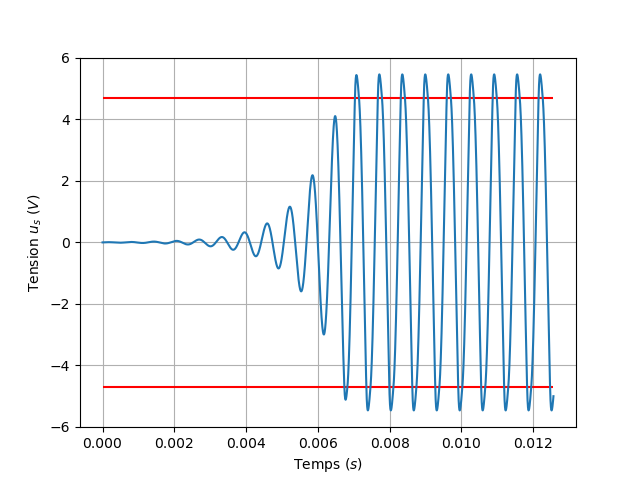

In [5]:
## On trace l'évolution temporelle de la tension de sortie du filtre
plt.figure('Signal')
plt.plot(t,X)
plt.hlines(R2*Usat/(R1+R2),min(t),max(t),color='r')
plt.hlines(-R2*Usat/(R1+R2),min(t),max(t),color='r')
plt.grid(True)
plt.xlabel(r'Temps $(s)$')
plt.ylabel(r'Tension $u_s$ $(V)$')
plt.show()

Les lignes rouges représentent les frontières $\left|u_s\right|\leq \frac{R_2}{R_1+R_2}U_\text{sat}$. On peut alors remarquer l'effet stabilisant du fonctionnement en saturation de l'ALI.

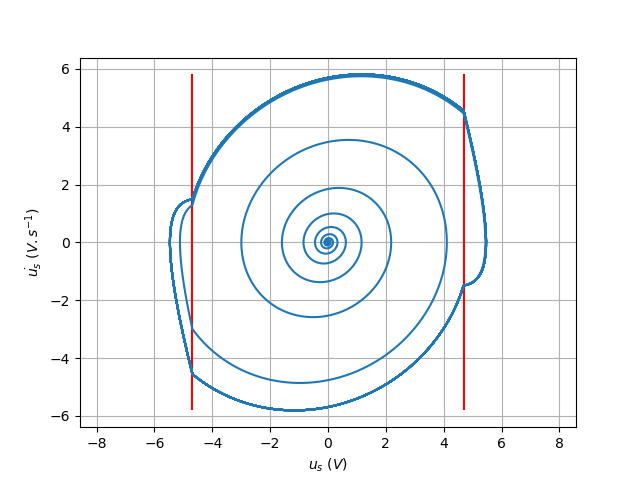

In [6]:
## On trace le portrait de phase de la tension de sortie du filtre
plt.figure('Portrait de phase')
plt.grid(True)
plt.axis('equal')
plt.plot(X,Xpoint/omega0)
plt.vlines(R2*Usat/(R1+R2),min(Xpoint/omega0),max(Xpoint/omega0),color='r')
plt.vlines(-R2*Usat/(R1+R2),min(Xpoint/omega0),max(Xpoint/omega0),color='r')
plt.xlabel(r'$u_s$ $(V)$')
plt.ylabel(r'$\dot{u_s}$ $(V.s^{-1})$')
plt.show()

La bascule périodique entre régime linéaire et de saturation du fonctionnement de l'ALI a pour conséquence un enrichissement spectral du signal obtenu, d'autant plus flagrant que la durée passée en mode de saturation est grande.

&nbsp;
On peut le vérifier en traçant le spectre du signal, et en modifiant les paramètres de fonctionnement de l'oscillateur.

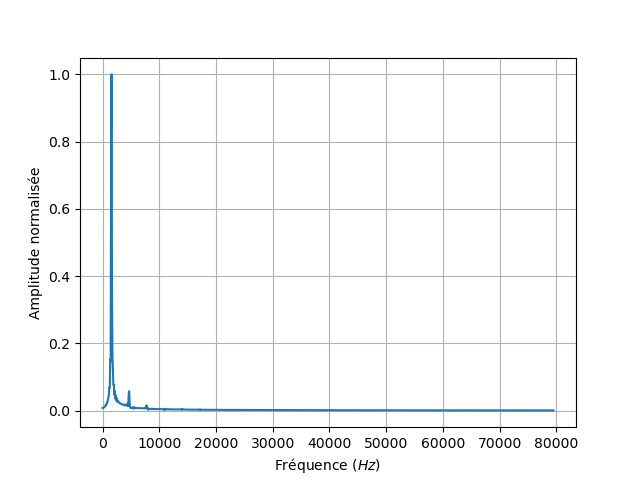

La pulsation dominante du signal de sortie est :  1.000e+04 rad.s^{-1}
La pusation propre est :  1.000e+04 rad.s^{-1}


In [7]:
## On utilise le module fft.fft de scipy
Y = fft.fft(X,nd)
nf=nd/20 # Affichage réduit de la plage de fréquences calculées
Y = Y[:int(nf)]
frq = np.arange(nd)/(Tmax) # Création de l'axe des abscisses
frq = frq[:int(nf)]
imax=np.argmax(abs(Y)) # On cherche la valeur maximale de la FFT pour normalisation

plt.figure('FFT')
plt.plot(frq,abs(Y)/max(abs(Y)))
plt.grid(True)
plt.xlabel(r'Fréquence $(Hz)$')
plt.ylabel(r'Amplitude normalisée')
plt.show()

print("La pulsation dominante du signal de sortie est : ",format(2*np.pi*frq[imax],"#.3e"),"rad.s^{-1}")
print("La pusation propre est : ",format(omega0,"#.3e"),"rad.s^{-1}")